In [1]:
# preprocessing
import pandas as pd
import numpy as np
import math

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# machine learning 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor # a lot of Decision Trees
from sklearn.neighbors import KNeighborsRegressor

# Support Functions

In [2]:
def get_df_null_info(df):
    '''analzyse sparse columns (= many NaNs/Null-Values)'''
    nulls:pd.Series =df.isnull().sum(axis = 0).sort_values(ascending = False)
    df_null_info:pd.DataFrame = pd.DataFrame(data={
        'nulls_amount': nulls,
        'nulls_percentage': nulls.apply(lambda row: round((row/df.shape[0])*100,2))
    })
    return df_null_info

def get_info_about_price(df):
    mean = math.floor(df[col_y].mean())
    max = math.floor(df[col_y].max())
    min = math.floor(df[col_y].min())
    print(f"'Price': Mean = {mean}\t\t Min = {min} \t Max = {max}")

# Get to know the data

In [3]:
# load dataset
df_source = pd.read_csv("germany_housing_data_14.07.2020.csv", sep=",")

# check how many null values are inside of dataset
df_null_info = get_df_null_info(df_source)
df_null_info
col_y = "Price"

In [4]:
# get some statistical information about dataset
df_source.describe(include="all")
get_info_about_price(df_source)

'Price': Mean = 556685		 Min = 0 	 Max = 13000000


# Pre-Processing

### Data Reduction (Dimensionality Reduction)

In [5]:
# Drop all columns:
#  (a) with more than 30% null values
#  (b) 'City' & 'Place' because  'State', 'City', and 'Place' have same information but with different granularity
drop_col_percentage_treshold=26
cols_to_drop = list(df_null_info[(df_null_info['nulls_percentage'] > drop_col_percentage_treshold)].index.values) 
cols_to_drop.append('City')
cols_to_drop.append('Place')
print(f'Drop following columns: {cols_to_drop}')

df_source.drop(columns=cols_to_drop, inplace=True)

Drop following columns: ['Energy_consumption', 'Year_renovated', 'Usable_area', 'Energy_efficiency_class', 'Bedrooms', 'Free_of_Relation', 'Energy_certificate_type', 'City', 'Place']


### Data Cleaning (handle missing data)

In [6]:
df_null_info = get_df_null_info(df_source)
df_null_info

,nulls_amount,nulls_percentage
Furnishing_quality,2726,25.83
Floors,2664,25.25
Garagetype,1960,18.57
Garages,1960,18.57
Bathrooms,1801,17.07
Energy_source,1227,11.63
Energy_certificate,755,7.16
Year_built,694,6.58
Heating,584,5.53
Type,402,3.81


Start to clean each column.

In [7]:
# for column 'State' drop all rows with no state
df_source.drop(df_source[df_source['State'].isnull()].index, inplace=True)
df_source.loc[df_source['State'].isnull()]

# for all other columns: fill NaNs with mode value
for col in df_source:
    df_source[col].fillna(df_source[col].mode()[0], inplace=True)

In [8]:
df_source.sample(2)

,Unnamed: 0,Price,Type,Living_space,Lot,Rooms,Bathrooms,Floors,Year_built,Furnishing_quality,Condition,Heating,Energy_source,Energy_certificate,State,Garages,Garagetype
4654,4654,41000.0,Bungalow,20.0,0.0,2.0,2.0,1.0,1900.0,refined,maintained,central heating,Gas,available,Mecklenburg-Vorpommern,1.0,Garage
3121,3121,1200000.0,Mid-terrace house,376.0,786.0,11.0,2.0,2.0,1997.0,luxus,dilapidated,central heating,Gas,available,Brandenburg,1.0,Garage


### Data Cleaning (Outlier Removal)

In [9]:
df_source.dtypes

Unnamed: 0              int64
Price                 float64
Type                   object
Living_space          float64
Lot                   float64
Rooms                 float64
Bathrooms             float64
Floors                float64
Year_built            float64
Furnishing_quality     object
Condition              object
Heating                object
Energy_source          object
Energy_certificate     object
State                  object
Garages               float64
Garagetype             object
dtype: object

In [10]:
## remove outlier: z_score transformation

# get all numerical columns
cols_to_zscore = list(df_source.select_dtypes(include='float64'))
cols_zscore = []

# create df with zscore-columns 
for col in cols_to_zscore:
    col_zscore = col + '_zscore'
    cols_zscore.append(col_zscore)
    
    # zscore of x in column :    (x- col.mean)-col.std
    # -> add an extra column for zscore
    df_source[col_zscore] = (df_source[col] - df_source[col].mean())/df_source[col].std(ddof=0)

In [11]:
cols_zscore

['Price_zscore',
 'Living_space_zscore',
 'Lot_zscore',
 'Rooms_zscore',
 'Bathrooms_zscore',
 'Floors_zscore',
 'Year_built_zscore',
 'Garages_zscore']

In [12]:
treshhold = 3
treshhold_range = [-treshhold, treshhold]

df_source["max_zscore"] = df_source[cols_zscore].max(axis=1) 
df_source['min_zscore'] = df_source[cols_zscore].min(axis=1) 


df_source['is_outlier_zscore'] = (
    (treshhold <= df_source["max_zscore"]) | 
    (df_source["max_zscore"] <= -treshhold ) | 

    (treshhold  <= df_source["min_zscore"]) | 
    (df_source["min_zscore"]  <= -treshhold )
)


Detected 966 rows as outliers.
'Price': Mean = 499877		 Min = 51000 	 Max = 2350000


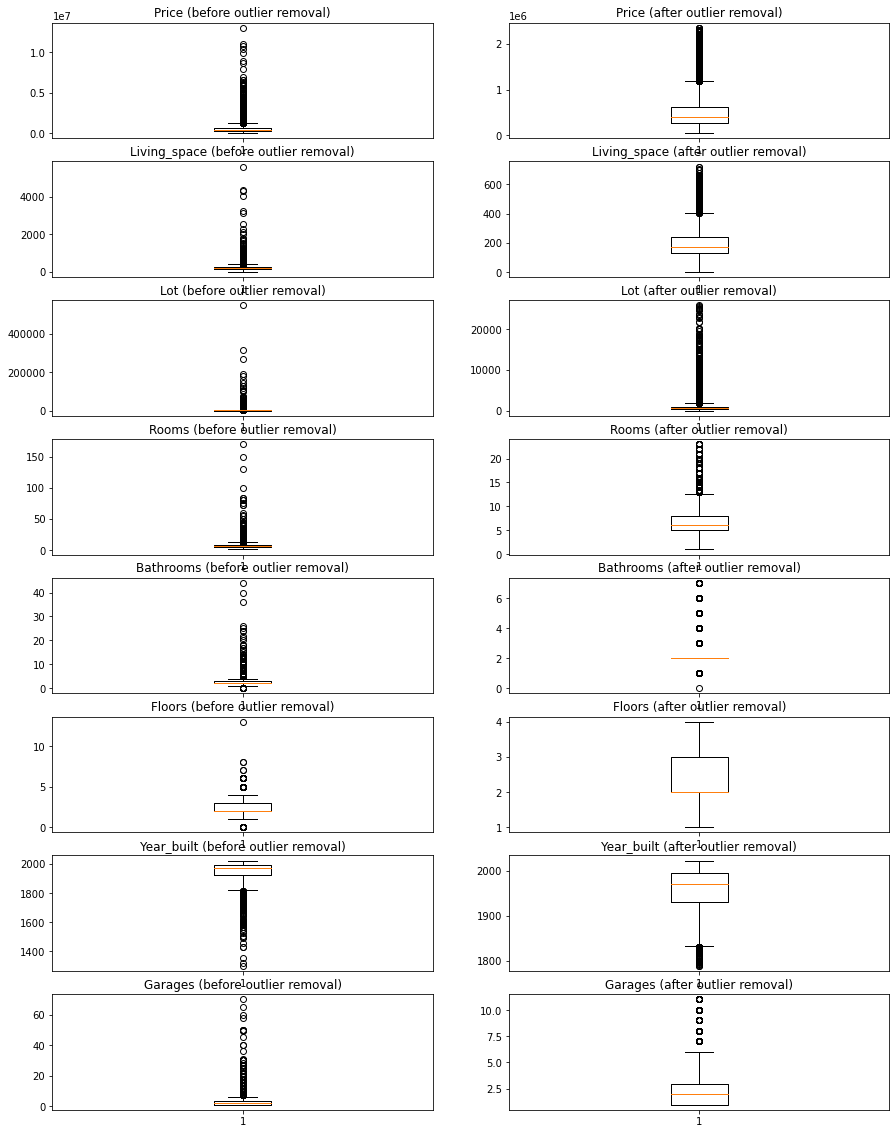

In [13]:

price_min  = 50000
price_max  = 10000000

df_new = df_source.loc[  (df_source['is_outlier_zscore'] == False) & (df_source[col_y] > price_min) & (df_source[col_y] < price_max)]
amount_of_outliers = len(df_source) - len(df_new)
print(f"Detected {amount_of_outliers} rows as outliers.")


fig = plt.figure( figsize=(15, 20))
id=1
for i in range(0,len(cols_to_zscore)):
    col = cols_to_zscore[i] 

    # old one
    ax = fig.add_subplot(8,2,id)
    ax.boxplot(df_source[col])
    ax.set_title(f"{col} (before outlier removal)")
    id=id+1

    # new one
    ax = fig.add_subplot(8,2,id)
    ax.boxplot(df_new[col])
    ax.set_title(f"{col} (after outlier removal)")
    id=id+1

get_info_about_price(df_new)

In [14]:
### drop zscore cols
df_source = df_new.drop(columns= [col for col in df_new.columns if col.endswith('_zscore')])
df_source.columns

Index(['Unnamed: 0', 'Price', 'Type', 'Living_space', 'Lot', 'Rooms',
       'Bathrooms', 'Floors', 'Year_built', 'Furnishing_quality', 'Condition',
       'Heating', 'Energy_source', 'Energy_certificate', 'State', 'Garages',
       'Garagetype'],
      dtype='object')

### Data Transformation (One-hot encoding)

In [15]:
cols_categorical = list(df_source.select_dtypes(include='object'))
cols_categorical

['Type',
 'Furnishing_quality',
 'Condition',
 'Heating',
 'Energy_source',
 'Energy_certificate',
 'State',
 'Garagetype']

In [16]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of categorical columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for col in cols:
        # new df of one hot values
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=False)
        # Drop column B as it is now encoded
        df = df.drop(col ,axis = 1)
        # Join the encoded df
        df = df.join(one_hot)

    return df

df_source = one_hot(df_source, cols_categorical)
df_source.columns = df_source.columns.str.replace(' ','-')
df_source = df_source.drop(columns='Unnamed:-0')
df_source.sample(3)

,Price,Living_space,Lot,Rooms,Bathrooms,Floors,Year_built,Garages,Type_Bungalow,Type_Castle,...,State_Sachsen-Anhalt,State_Schleswig-Holstein,State_Thüringen,Garagetype_Car-park-lot,Garagetype_Carport,Garagetype_Duplex-lot,Garagetype_Garage,Garagetype_Outside-parking-lot,Garagetype_Parking-lot,Garagetype_Underground-parking-lot
8367,239000.0,265.00,900.0,9.0,3.0,2.0,1975.0,2.0,0,0,...,0,0,0,0,0,0,1,0,0,0
7962,998700.0,312.15,2359.0,8.0,4.0,3.0,1960.0,4.0,0,0,...,0,0,0,0,0,0,1,0,0,0
8877,370000.0,218.00,642.0,10.0,2.0,2.0,1994.0,2.0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Data Transformation (Rearrange Dataframe)

In [17]:
# split into X and Y
col_y = "Price"
df_y:pd.DataFrame = df_source.drop(df_source.columns.difference([col_y]), 1)
df_X:pd.DataFrame = df_source.drop(columns=col_y)
df_source = pd.concat([df_X, df_y], axis=1, join='inner')
df_source.sample(2)

,Living_space,Lot,Rooms,Bathrooms,Floors,Year_built,Garages,Type_Bungalow,Type_Castle,Type_Corner-house,...,State_Schleswig-Holstein,State_Thüringen,Garagetype_Car-park-lot,Garagetype_Carport,Garagetype_Duplex-lot,Garagetype_Garage,Garagetype_Outside-parking-lot,Garagetype_Parking-lot,Garagetype_Underground-parking-lot,Price
7078,210.0,701.0,5.0,1.0,1.0,1983.0,3.0,0,0,0,...,0,0,0,0,0,1,0,0,0,525000.0
2524,160.0,687.0,5.0,2.0,2.0,1993.0,2.0,0,0,0,...,0,0,0,0,0,1,0,0,0,335000.0


### Data Reduction (Feature Selection)

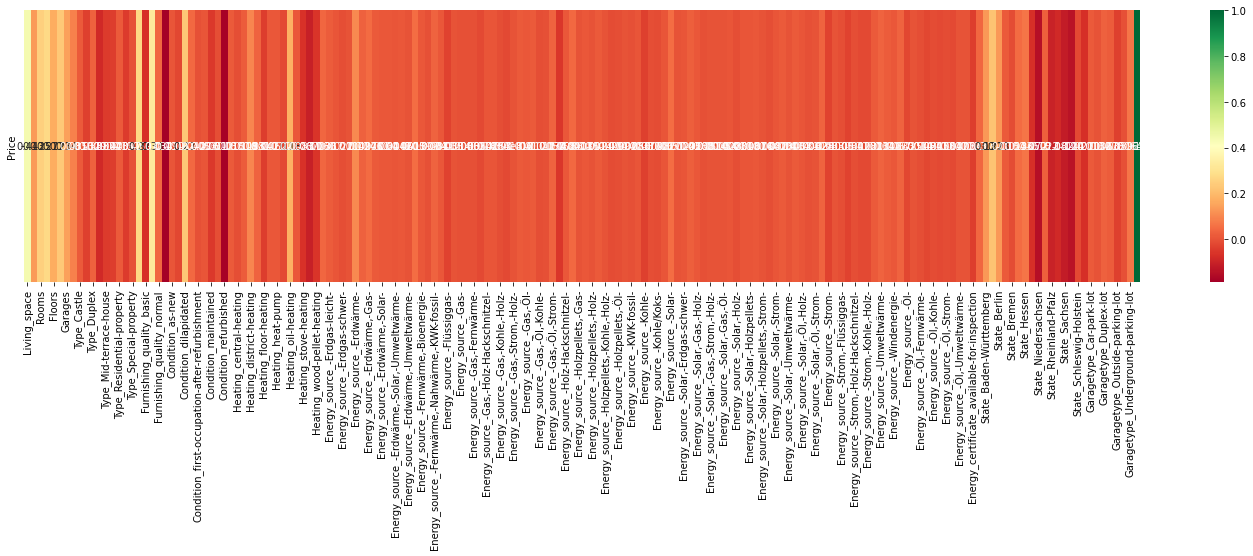

In [18]:
'''
Plot correlation between price and all features to get an idea what kind of features have an impact.
'''
# plot heat map showing features which have biggest effect on price
plt.figure(figsize=(25,5))
g=sns.heatmap(df_source.corr().loc[[col_y],:],annot=True,cmap="RdYlGn")

In [19]:
def get_top_corr_features(df, col_y="Price", min_corr_factor=0.2):
    ''' DATA REDUCTION: Feature Selection
    Select best (high correlation) features from data set
    '''
    cor = df.corr()
    cor_target = abs(cor[col_y])

    # get most significant features which correlate with output-variable y
    relevant_features = cor_target[cor_target > min_corr_factor]
    selected_features = list(relevant_features.index)
    print(f"These are selected features: {relevant_features}")

    return selected_features

### opt. Data Transformation (Scaling features)

In [20]:
# from sklearn.preprocessing import StandardScaler
# 
# k = 3
# # only scale columns which are not one hot encoded
# scaler = StandardScaler().fit(X_train[:,:k])
# 
# def preprocessor(X):
#   A = np.copy(X)
#   A[:, :k] = scaler.transform(A[:, :k])
#   return A
# 
# X_train, X_test = preprocessor(X_train), preprocessor(X_test)

### Data Transformation (Split into Train & Test)

In [21]:
def split_df_into_train_test(df):
    '''     split dataframe into training and test data '''
    X = df.to_numpy()[:, :-1]
    y = df.to_numpy()[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #print(f"Shapes for train/test/val:\t {X_train.shape}, {y_train.shape} / {X_test.shape}, {y_test.shape}")
    return X_train, X_test, y_train, y_test

# Learning Algorithms

In [22]:
# define loss function (RMSE)
def calc_loss(model, X, y):
    '''calculate loss in form of RMSE of a model'''
    return math.floor(mse(model.predict(X), y, squared=False))

### Experiment 1: Plot Model for different top features

Train linear regression model for different top features & plot model

These are selected features: Living_space                0.441988
Rooms                       0.250572
Bathrooms                   0.271603
Type_Villa                  0.266288
Furnishing_quality_luxus    0.325471
Price                       1.000000
Name: Price, dtype: float64


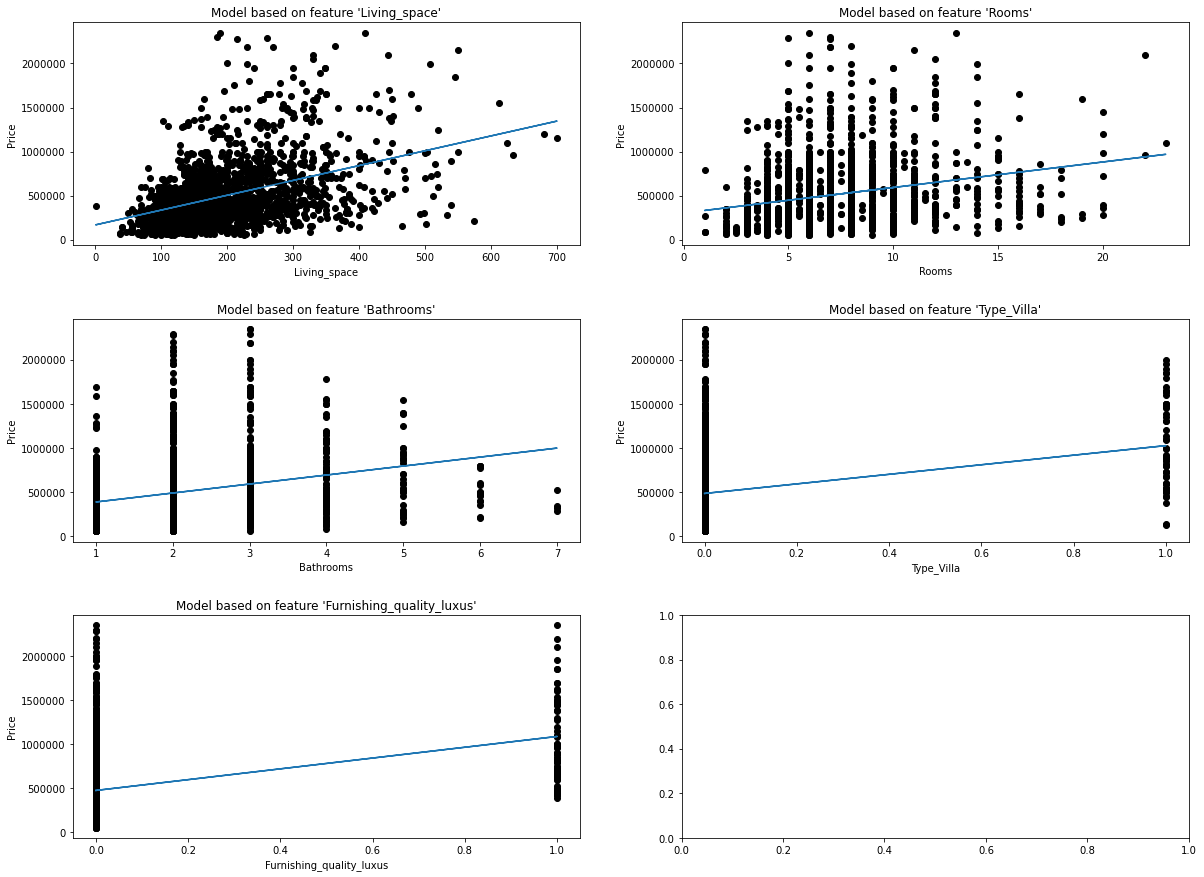

In [23]:
# calc list of top features
list_top_features = get_top_corr_features(df=df_source, min_corr_factor=0.25)
list_top_features.remove(col_y)


list_loss_train = []
list_loss_test = []

ncols= 2
nrows= math.ceil(len(list_top_features)/ncols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_figheight(nrows*5)
fig.set_figwidth(20)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.33)


for i, feature in enumerate(list_top_features):
    # create dataframe only with one feature
    df_model = df_source.drop(columns=df_source.columns.difference([feature, col_y]))

    # split dataframe into train & test
    X_train, X_test, y_train, y_test = split_df_into_train_test(df=df_model)

    # train linear regression model
    model_linear = LinearRegression().fit(X_train, y_train)

    # calc loss for train & test
    loss_train = calc_loss(model_linear, X_train, y_train)
    loss_test  = calc_loss(model_linear, X_test, y_test)

    list_loss_train.append(loss_train)
    list_loss_test.append(loss_test)

    # plot 
    y_pred = model_linear.predict(X_test)
    i_row = math.floor(i/2)
    i_col = i%2

    axs[i_row][i_col].ticklabel_format(useOffset=False)
    axs[i_row][i_col].scatter(X_test, y_test, color="black")
    axs[i_row][i_col].plot(X_test, y_pred)
    axs[i_row][i_col].ticklabel_format(style='plain')
    axs[i_row][i_col].set_title(f"Model based on feature '{feature}'")
    axs[i_row][i_col].set_xlabel(f'{feature}')
    axs[i_row][i_col].set_ylabel(f'{col_y}')



Plot loss (RMSE) (training & test data) for the different models

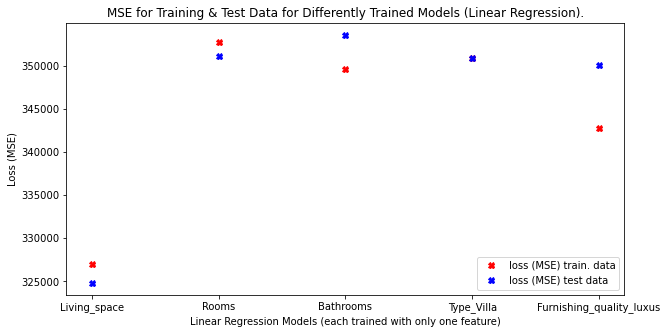

In [24]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
ax.plot(list_top_features, list_loss_train, label="Loss (RMSE) train. data", linestyle = 'None', marker="X", color="r")
ax.plot(list_top_features, list_loss_test, label="Loss (RMSE) test data", linestyle = 'None', marker="X", color="b")
ax.legend()
ax.set_title("RMSE for Training & Test Data for Differently Trained Models (Linear Regression).")
ax.set_xlabel("Linear Regression Models (each trained with only one feature)")
ax.set_ylabel("Loss (RMSE)")
plt.show()

Result of Experiment 1: Linear Regression Model trained with "Living_space" has lowest RMSE, so it has best performance.

### Experiment 2: Compare different models with different amount of top features

Train different models with different amount of top features

In [25]:
mtrx_loss_train = [[],[],[]]
mtrx_loss_test  = [[],[],[]]

for i, feature in enumerate(list_top_features):
     # create dataframe only with one feature
    cols = list_top_features[:i+1]
    cols.append(col_y)
    df_model = df_source.drop(columns=df_source.columns.difference(cols))

    # split dataframe into train & test
    X_train, X_test, y_train, y_test = split_df_into_train_test(df=df_model)

    # model = linear regression
    model_linear = LinearRegression().fit(X_train, y_train)
    mtrx_loss_train[0].append(calc_loss(model_linear, X_train, y_train))
    mtrx_loss_test[0].append(calc_loss(model_linear, X_test, y_test))
    
    # model = knn
    model_knn = KNeighborsRegressor(n_neighbors=20).fit(X_train, y_train)
    mtrx_loss_train[1].append(calc_loss(model_knn, X_train, y_train))
    mtrx_loss_test[1].append(calc_loss(model_knn, X_test, y_test))

    # model = random forest
    model_rfr = RandomForestRegressor(max_depth=2).fit(X_train, y_train)
    mtrx_loss_train[2].append(calc_loss(model_rfr, X_train, y_train))
    mtrx_loss_test[2].append(calc_loss(model_rfr, X_test, y_test))

Also train these models with all existing features (d=171)

In [26]:
# use all features
df_model = df_source

# split dataframe into train & test
X_train, X_test, y_train, y_test = split_df_into_train_test(df=df_model)

# model = linear regression
model_linear = LinearRegression().fit(X_train, y_train)
mtrx_loss_train[0].append(calc_loss(model_linear, X_train, y_train))
mtrx_loss_test[0].append(calc_loss(model_linear, X_test, y_test))

# model = knn
model_knn = KNeighborsRegressor(n_neighbors=9).fit(X_train, y_train)
mtrx_loss_train[1].append(calc_loss(model_knn, X_train, y_train))
mtrx_loss_test[1].append(calc_loss(model_knn, X_test, y_test))

# model = random forest
model_rfr = RandomForestRegressor(max_depth=6).fit(X_train, y_train)
mtrx_loss_train[2].append(calc_loss(model_rfr, X_train, y_train))
mtrx_loss_test[2].append(calc_loss(model_rfr, X_test, y_test))

For each model create a subplot which shows how RMSE develops when using different amount of features for trainings phase

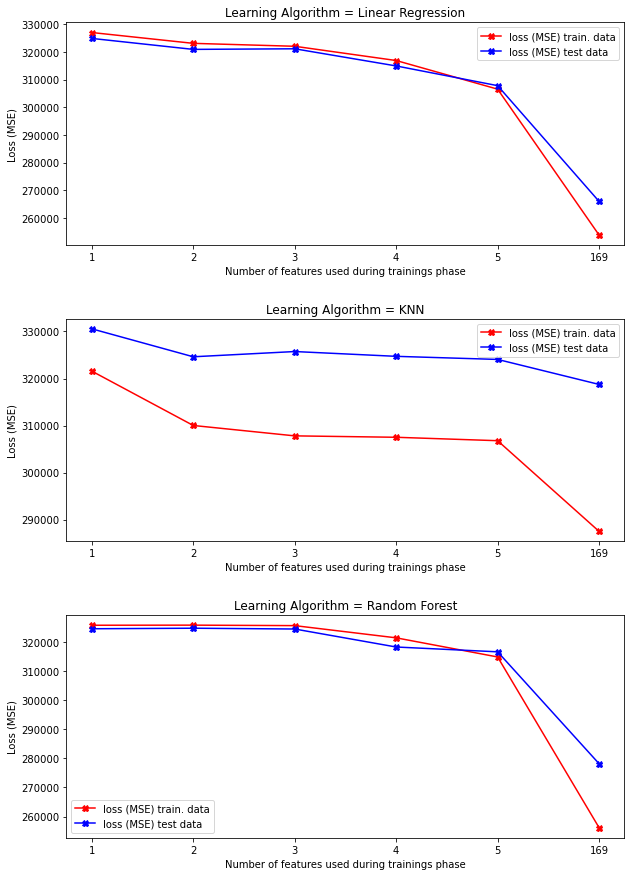

In [27]:
list_number_features = list(range(1, len(list_top_features)+1, 1))
list_number_features.append(len(df_source.columns)-1)
list_number_features = list(map(lambda x: f'{x}', list_number_features))

list_models = ["Linear Regression", "K-nearest-neighbors", "Random Forest"]


fig, axs = plt.subplots(len(list_models))
fig.set_figheight(len(list_models)*5)
fig.set_figwidth(10)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.33)

for i, model in enumerate(list_models):
    axs[i].plot(list_number_features, mtrx_loss_train[i], label="Loss (RMSE) train. data", marker="X", color="r")
    axs[i].plot(list_number_features, mtrx_loss_test[i], label="Loss (RMSE) test data", marker="X", color="b")
    
    axs[i].xaxis.set_ticks(list_number_features)
    #axs[i].yaxis.set_ticks(np.arange(300000, 350000, 50000))

    axs[i].set_xlabel(f'Number of features used during trainings phase')
    axs[i].set_title(f'Learning Algorithm = {model}')
    axs[i].set_ylabel(f'Loss (RMSE)')
    axs[i].legend()
    
plt.show()

Result of Experiment 2: Overall it can be said that the lowest loss (RMSE) is achivied by a linear regression model which uses all 171 features.
Here, loss in training and test data are almost the same. This implies that overfit is not existing.
However, the loss is still high (RMSE ~260000).

# Results

265938


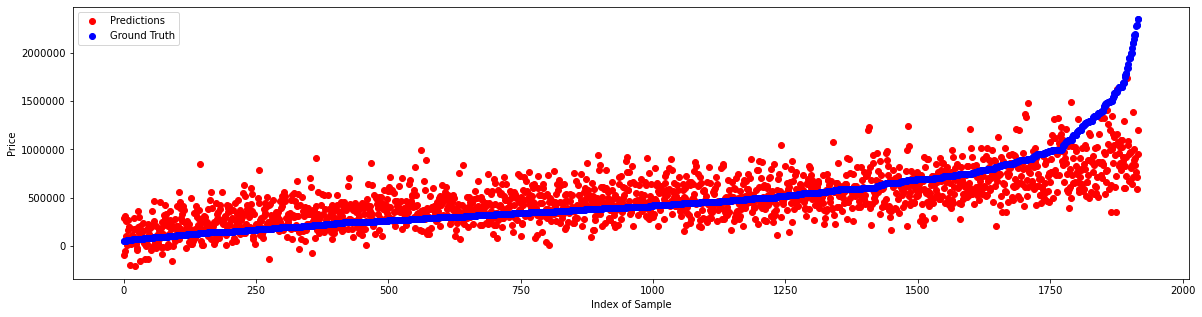

In [28]:
df_model = df_source
X_train, X_test, y_train, y_test = split_df_into_train_test(df=df_model)

# create df for test data 
cols_df_test = list(df_source.columns)
cols_df_test.remove(col_y)

df_test_X = pd.DataFrame(data=X_test, columns=cols_df_test)
df_test_Y = pd.DataFrame(data=y_test, columns=[col_y])
df_test = pd.concat([df_test_X, df_test_Y], axis=1)

# order test set based on price (ascending)
df_test.sort_values(by=[col_y], ascending=True, inplace=True)
X_test, y_test = df_test.to_numpy()[:, :-1], df_test.to_numpy()[:, -1]

# train linear regression model
model_linear = LinearRegression().fit(X_train, y_train)
print(calc_loss(model=model_linear, X=X_test, y=y_test))

# do predictions based ordered test set
y_pred_test = model_linear.predict(X_test)

# plot prices for ordered test data 
x_axis = np.arange(0, len(y_test), 1)

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
ax.scatter(x_axis,y_pred_test, label="Predictions",  color="r")
ax.scatter(x_axis,y_test, label="Ground Truth",  color="b")


ax.legend()
ax.ticklabel_format(style='plain')

#ax.set_title("Comparison between Ground Truth and Predictions for y-variable (Price)")
ax.set_xlabel("Index of Sample")
ax.set_ylabel("Price")
plt.show()

In [29]:
df_a = pd.DataFrame(data=y_test, columns=["Ground Truth"])
df_b = pd.DataFrame(data=y_pred_test, columns=["Pred"])
df_c = pd.concat([df_a, df_b], axis=1)

for _, row in df_c.iterrows():
    ground_truth = math.floor(row['Ground Truth'])
    pred = math.floor(row['Pred'])
    distance = math.floor(math.sqrt((pred-ground_truth)**2))

    print(f"{ground_truth}\t\t{pred}\t\t{distance}")

51500		287081		235581
52000		-95002		147002
53900		313308		259408
54450		-52666		107116
55000		99543		44543
55000		254372		199372
56000		72972		16972
56500		10858		45642
59000		162390		103390
59000		270556		211556
59900		196300		136400
60000		198641		138641
60000		-200667		260667
60000		26869		33131
61000		26405		34595
62000		16692		45308
63000		108806		45806
68000		106059		38059
68000		68373		373
69000		286013		217013
69000		179030		110030
69000		179128		110128
69000		-213484		282484
69000		14788		54212
69000		48643		20357
69000		-40291		109291
69000		-19763		88763
69000		358414		289414
69500		197765		128265
69990		132667		62677
70000		301282		231282
70000		-153766		223766
70000		207142		137142
75000		102343		27343
75000		61638		13362
75000		102502		27502
75000		151085		76085
75000		235551		160551
78000		35946		42054
78000		26541		51459
78000		18267		59733
78000		-139804		217804
79000		75963		3037
79000		-2261		81261
79000		18317		60683
79000		175920		96920
79000		-134552		213552
7950